# Preamble
## Setup of environment

In [ ]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
# !pip install voxelmorph

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Cardiac Project/Registration_phase/voxelMorph/source_code

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1T4XU2DwFBpucge5DbMQ0wVZaRLkXQ564/Cardiac Project/Registration_phase/voxelMorph/source_code


In [ ]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

Next, we import two packages that will help us   
- [voxelmorph](http://voxelmorph.mit.edu) is a deep-learning based registration library  
- [neurite](https://github.com/adalca/neurite) is a library for medical image analysis with tensorflow 

We use setup.py to install requirements.

In [ ]:
!pip install .

Processing /content/gdrive/.shortcut-targets-by-id/1T4XU2DwFBpucge5DbMQ0wVZaRLkXQ564/Cardiac Project/Registration_phase/voxelMorph/source_code
     |████████████████████████████████| 92kB 8.6MB/s 
  Created wheel for voxelmorph: filename=voxelmorph-0.1-cp37-none-any.whl size=63846 sha256=a2938b962b8bc007f24f41c36ff0be608280b20ef5a55d0e2dbb6d3edb0177b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-pyk8rakr/wheels/e0/c1/9b/0112d50750456a3777a630d579ad34ebed587b187059cacaa1
Successfully built voxelmorph


In [ ]:
# local imports
import voxelmorph as vxm
import neurite as ne

---

# Data

## Load

In [ ]:
import glob
import imageio

### load cine images for training dataset
cine_train = []
print("cine_train: ", end="")
for image_path in glob.glob("../cine_images/*.png"):
    image = imageio.imread(image_path)
    i = int(image_path.split('/')[-1].split('_')[0])
    cine_train.append((image, i))
    print(i, end=" ")
cine_train.sort(key=lambda x: x[1])
cine_train_images = []
for t in  cine_train:
    cine_train_images.append(t[0])
cine_train = np.array(cine_train_images)

### load lge images for training dataset
lge_train = []
print()
print("lge_train: ", end="")
for image_path in glob.glob("../lge_images/*.png"):
    image = imageio.imread(image_path)
    i = int(image_path.split('/')[-1].split('_')[0])
    lge_train.append((image, i))
    print(i, end=" ")
lge_train.sort(key=lambda x: x[1])
lge_train_images = []
for t in  lge_train:
    lge_train_images.append(t[0])
lge_train = np.array(lge_train_images)

cine_train: 1 4 5 2 3 6 7 8 9 10 11 12 13 16 15 17 14 19 18 21 20 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 61 62 63 64 65 66 67 60 68 69 70 71 72 73 74 75 77 76 78 79 80 82 81 83 84 85 86 87 88 89 90 91 92 93 94 95 97 96 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 118 117 120 119 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 167 166 168 169 170 171 172 173 174 175 176 177 179 178 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 203 204 202 206 205 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 226 225 227 228 229 230 233 232 231 234 235 236 237 238 239 240 241 242 243 244 245 247 246 248 249 251 252 253 250 254 256 255 257 259 260 258 267 261 268 269 270 262 271 263 264 272 273 265 274 275 

In [ ]:
# let's get some shapes to understand what we loaded.
print('shape of cine_train: {}, lge_train: {}'.format(cine_train.shape, lge_train.shape))

shape of cine_train: (299, 64, 64), lge_train: (299, 64, 64)


## Normalize & Visualize

In [ ]:
# fix data
cine_train = cine_train.astype('float')/255
lge_train = lge_train.astype('float')/255

In [ ]:
# verify
print('cine_train maximum value', cine_train.max())
print('lge_train maximum value', lge_train.max())

cine_train maximum value 1.0
lge_train maximum value 1.0


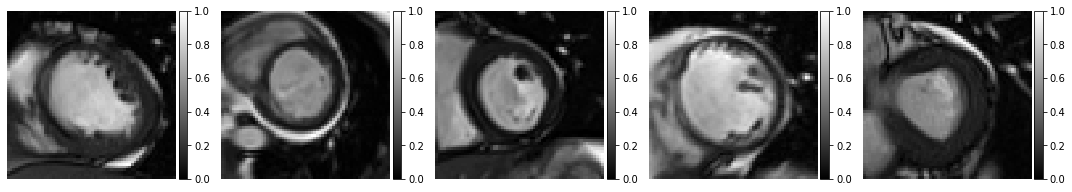

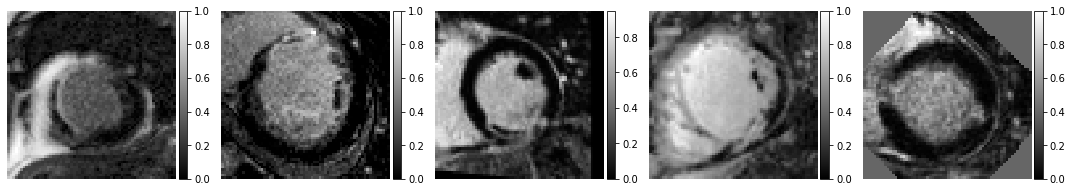

In [ ]:
idx = np.random.randint(0, cine_train.shape[0], size=5)
# visualize
cine_examples = [f for f in cine_train[idx, ...]]
lge_examples = [f for f in lge_train[idx, ...]]

# plot
ne.plot.slices(cine_examples, cmaps=['gray'], do_colorbars=True);
ne.plot.slices(lge_examples, cmaps=['gray'], do_colorbars=True);

In [ ]:
# verify
print('shape of cine training data', cine_train.shape)
print('shape of lge training data', lge_train.shape)

shape of cine training data (299, 64, 64)
shape of lge training data (299, 64, 64)


---

# CNN Model

In [ ]:
def vxm_data_generator(cine_data, lge_data, batch_size=32, indx=[]):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = cine_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx = np.random.randint(0, cine_data.shape[0], size=batch_size)
        if len(indx) > 0:
          idx = indx
        moving_images = lge_data[idx, ..., np.newaxis]
        fixed_images = cine_data[idx, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
def get_model(nb_features, lambda_param, adam_rate, batch_size, epochs, steps_per_epoch, sim_loss, smooth_loss=vxm.losses.Grad('l2').loss):
    inshape = cine_train.shape[1:]
    vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
    losses = [sim_loss, smooth_loss]
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=adam_rate), loss=losses, loss_weights=[1, lambda_param])
    train_generator = vxm_data_generator(cine_train, lge_train, batch_size=batch_size)
    hist = vxm_model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=2);
    return vxm_model, hist

In [ ]:
def show(vxm_model, indx):
    for i in indx:
        # get some data
        val_generator = vxm_data_generator(cine_train, lge_train, batch_size = 1, indx=[i])
        val_input, _ = next(val_generator)
        val_pred = vxm_model.predict(val_input)


        # visualize
        images = [img[0, :, :, 0] for img in val_input + val_pred] 
        titles = ['moving', 'fixed', 'moved', 'flow']
        ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# Train Models

In [ ]:
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

In [ ]:
vxm_models = []
hists = []

# NCC sim_loss
for i,lam in enumerate([0.5]):
    print()
    print("model number", i, "-----------------------------------------------------------")
    vxm_model, hist = get_model(nb_features, lambda_param=lam, adam_rate=1e-3, batch_size=20, epochs=50, steps_per_epoch=100, sim_loss=vxm.losses.NCC().loss)
    vxm_models.append(vxm_model)
    hists.append(hist)

# NMI sim_loss
for i,lam in enumerate([0.5]):
    print()
    print("model number", i, "-----------------------------------------------------------")
    vxm_model, hist = get_model(nb_features, lambda_param=lam, adam_rate=1e-3, batch_size=20, epochs=50, steps_per_epoch=100, sim_loss=vxm.losses.NCC().loss)
    vxm_models.append(vxm_model)
    hists.append(hist)


model number 0 -----------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 - 39s - loss: -3.0962e-01 - vxm_dense_transformer_loss: -3.1047e-01 - vxm_dense_flow_loss: 0.0085
Epoch 2/20
100/100 - 4s - loss: -4.1319e-01 - vxm_dense_transformer_loss: -4.2735e-01 - vxm_dense_flow_loss: 0.1415
Epoch 3/20
100/100 - 4s - loss: -4.6999e-01 - vxm_dense_transformer_loss: -4.9323e-01 - vxm_dense_flow_loss: 0.2324
Epoch 4/20
100/100 - 4s - loss: -5.0109e-01 - vxm_dense_transformer_loss: -5.2925e-01 - vxm_dense_flow_loss: 0.2815
Epoch 5/20
100/100 - 4s - loss: -5.2786e-01 - vxm_dense_transformer_loss: -5.5919e-01 - vxm_dense_flow_loss: 0.3133
Epoch 6/20
100/100 - 4s - loss: -5.4279e-01 - vxm_dense_transformer_loss: -5.7674e-01 - vxm_dense_flow_loss: 0.3395
Epoch 7/20
100/100 - 4s - loss: -5.5510e-01 - vxm_dense_transformer_loss: -5.9075e-01 - vxm_dense_flow_loss: 0.3565
Epoch 8/20
100/100 - 4s - loss: -5.6540e-01 - vxm_dense_transformer_loss: -6.0238e-01 - vxm_dense_flow_loss: 0.3698
Epoch 9/20
100/100 - 4s - loss: -5.7885e-01 - vxm_dense_transformer_los

# Show Results

model number 1 : 


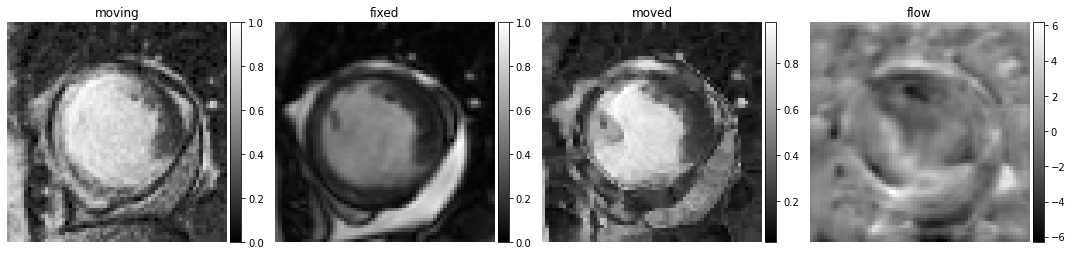

model number 2 : 


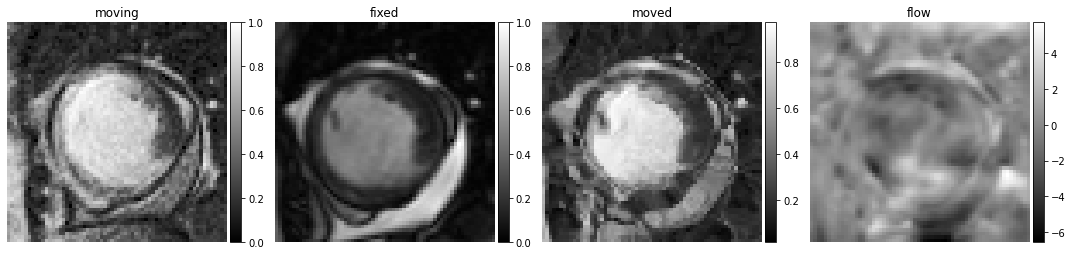

model number 3 : 


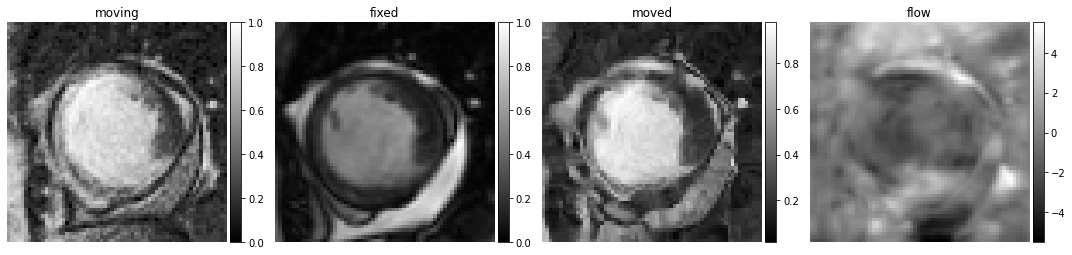

model number 4 : 


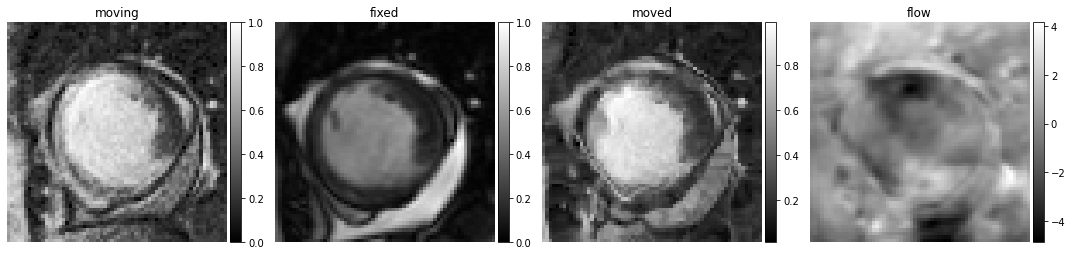

model number 5 : 


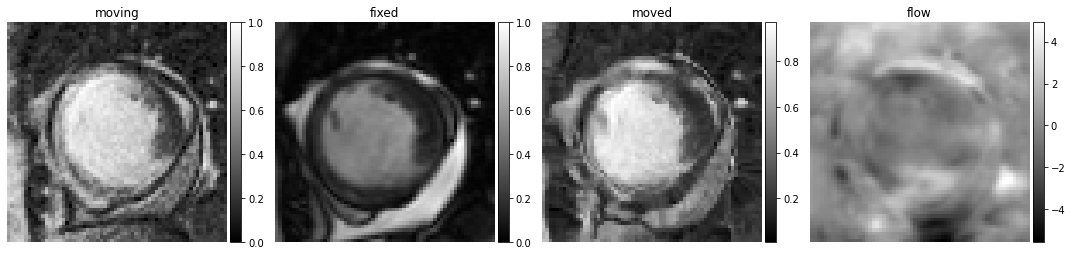

In [ ]:
indx = np.random.randint(0, cine_train.shape[0], size=1)
indx = [79]
for i, vxm_model in enumerate(vxm_models):
    print("model number", i+1, ": ")
    show(vxm_model=vxm_model, indx=indx)

model number 1 : 


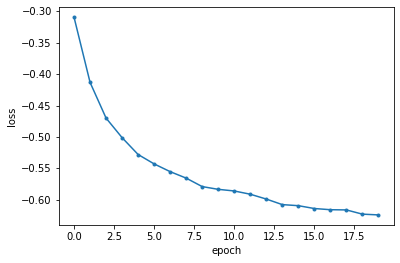

model number 2 : 


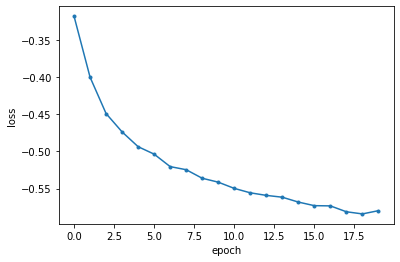

model number 3 : 


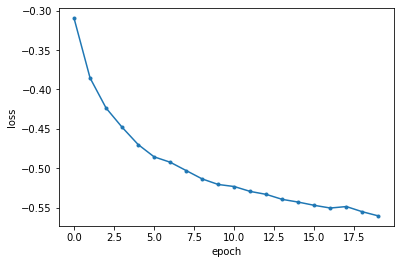

model number 4 : 


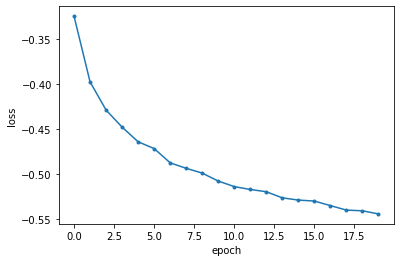

model number 5 : 


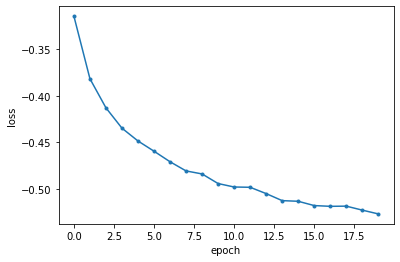

In [ ]:
for i, hist in enumerate(hists):
    print("model number", i+1, ": ")
    plot_history(hist)